# Unsupervised Learning for Melbourne Housing Data

## Table of Contents
1. [Introduction](#t1.)
2. [Notebook Setup](#t2.)
3. [Load in Datasets](#t3.)
4. [Data Understanding](#t4.)
4.1. [Property Type Datasets](#t4.1.)
4.2. [Feature Engineering - Over/Under Indicator](#t4.2.)
5. [Principal Component Analysis (PCA)](#t5.)
5.1. [Understanding PCA with Heatmaps](#5.1.)
6. [K-Means Clustering](#61.)
6.1. [Model Scoring](#t6.1.)
7. [Model Improvement with Elbow Plots](#t7.)
8. [Second Iteration Clustering](#t8.)
8.1. [Feature Engineering - Price Bins](#t8.1.)
9. [Third Iteration Clustering](#t9.)
9.1. [Model Scoring](#t9.1.)

<a id="t1."></a>
# Introduction
The objective of this clustering analysis is to attempt to find out if a property is over or undervalued. To accomplish this task we will employ the K-Means clustering method. Our dataset will be split into three dataframes, one for each property type (House, Apartment/Unit, and Townhouse). In doing so we are eliminating the obvious differences that occur between these types and increasing the accuracy of the clustering. In the normal application of unsupervised learning the attribute titles are unknown, but for our example they are. This will allow us to compare and contrast the actual results with the K-Mean generated clusters. 

By utilizing the continuous numeric features, we can attempt this classification task. Each property does contain many categoricals features, however the K-Means algorithm is not very supportive of this attribute type. The way in which clusters will be determined is through euclidean distance, so having the features be on a continuous scale is of paramount importance for the model to work successfully. 
Each data frame will contain only the continuous numeric values/features available to our datasets, these include:

- Distance
- Building Age
- Building Area (log)
- Land Size (log)


<a id="t2."></a>
# Notebook Setup

In [1]:
# Import Libraries

# Data Manipulation
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# Model Building
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import homogeneity_score
from sklearn.metrics import confusion_matrix,classification_report

<a id="t3."></a>
# Load in Data
The csv file used in this analysis is from the previous assignment. For a detail analysis of the data and for the steps taken to clean and prepare the data, see the previous notebook.

In [2]:
# Load data and set options to view all cols/features
pd.options.display.max_columns = 999
df = pd.read_csv('Completed_Melbourne_Housing.csv')

# Keep an original copy for later analysis
df_org = pd.read_csv('Completed_Melbourne_Housing.csv')

<a id="t4."></a>
# Data Understanding

In [3]:
# Create new column to show age of the building
df['BuildingAge'] = df['YearSold'] - df['YearBuilt']

In [4]:
# Remove all uneeded cols/features
data = df[['Type','Regionname','Distance','BuildingAge','log_BuildingArea','log_Landsize','log_Price']]

In [5]:
# View sample of dataframe, with the selected features
data.head()

,Type,Regionname,Distance,BuildingAge,log_BuildingArea,log_Landsize,log_Price
0,h,Southern Metropolitan,10.7,52,5.765352,6.584791,14.054527
1,h,Northern Metropolitan,12.0,44,4.429791,5.730100,13.173532
2,h,Western Metropolitan,7.5,95,5.231109,6.236370,14.177372
3,h,Western Metropolitan,10.5,92,5.222998,6.595781,13.715690
4,h,Northern Metropolitan,5.7,60,5.309905,6.579251,14.334304


In [6]:
# Basic descriptive statistics of new dataframe
data.describe()

,Distance,BuildingAge,log_BuildingArea,log_Landsize,log_Price
count,13117.000000,13117.000000,13117.000000,13117.000000,13117.000000
mean,10.197964,53.288709,4.871661,5.156715,13.731325
std,5.819587,31.405274,0.528674,2.222761,0.506303
min,0.000000,-2.000000,3.295837,0.000000,11.350407
25%,6.200000,31.000000,4.550968,5.147494,13.384728
50%,9.300000,51.000000,4.897840,6.054439,13.710150
75%,13.000000,70.000000,5.245804,6.472346,14.090107
max,47.400000,137.000000,6.839476,7.999007,15.019983


In [7]:
# Value counts of each region
data['Regionname'].value_counts()

Southern Metropolitan         4455
Northern Metropolitan         3769
Western Metropolitan          2894
Eastern Metropolitan          1442
South-Eastern Metropolitan     441
Eastern Victoria                50
Northern Victoria               36
Western Victoria                30
Name: Regionname, dtype: int64

In [8]:
# Apply standard scaler to the dataset
# Doing this here before it is split into the sub regions
data = StandardScaler().fit_transform(data[['Distance', 'BuildingAge', 'log_BuildingArea',
       'log_Landsize', 'log_Price']])

In [9]:
# Convert back to a dataframe object from a series
# Add back the 'Type' feature 
data = pd.DataFrame(data)
data = pd.concat([data,df['Type'],df['Regionname']],axis=1)
data.head()

,0,1,2,3,4,Type,Regionname
0,0.086270,-0.041036,1.690504,0.642503,0.638382,h,Southern Metropolitan
1,0.309662,-0.295780,-0.835839,0.257971,-1.101741,h,Northern Metropolitan
2,-0.463618,1.328213,0.679931,0.485746,0.881022,h,Western Metropolitan
3,0.051902,1.232684,0.664588,0.647447,-0.030882,h,Western Metropolitan
4,-0.772930,0.213708,0.828982,0.640011,1.190991,h,Northern Metropolitan


In [10]:
# Relabel columns
# Maybe not exactly necessary, for this application 
data.columns = ['Distance', 'BuildingAge', 'log_BuildingArea',
       'log_Landsize', 'log_Price','Type','Regionname']

In [11]:
# Display data
data.head()

,Distance,BuildingAge,log_BuildingArea,log_Landsize,log_Price,Type,Regionname
0,0.086270,-0.041036,1.690504,0.642503,0.638382,h,Southern Metropolitan
1,0.309662,-0.295780,-0.835839,0.257971,-1.101741,h,Northern Metropolitan
2,-0.463618,1.328213,0.679931,0.485746,0.881022,h,Western Metropolitan
3,0.051902,1.232684,0.664588,0.647447,-0.030882,h,Western Metropolitan
4,-0.772930,0.213708,0.828982,0.640011,1.190991,h,Northern Metropolitan


In [12]:
# Basic descriptive statistics 
data.describe()

,Distance,BuildingAge,log_BuildingArea,log_Landsize,log_Price
count,1.311700e+04,1.311700e+04,1.311700e+04,1.311700e+04,1.311700e+04
mean,1.595464e-15,7.198464e-16,-1.149750e-16,1.439803e-15,-5.061134e-16
std,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00
min,-1.752419e+00,-1.760558e+00,-2.980824e+00,-2.320048e+00,-4.702736e+00
25%,-6.870104e-01,-7.097394e-01,-6.066207e-01,-4.148225e-03,-6.845914e-01
50%,-1.543063e-01,-7.287937e-02,4.952015e-02,4.038936e-01,-4.182442e-02
75%,4.815019e-01,5.321376e-01,7.077288e-01,5.919134e-01,7.086587e-01
max,6.392800e+00,2.665619e+00,3.722315e+00,1.278771e+00,2.545329e+00


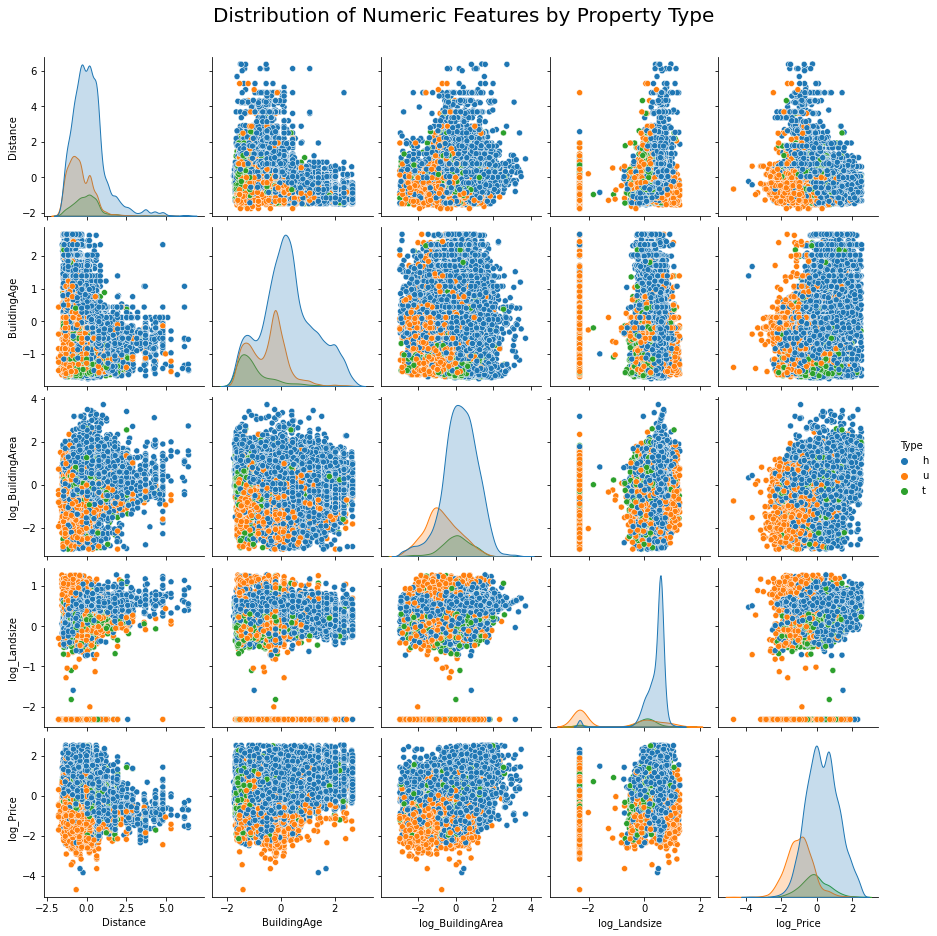

In [13]:
# Show pairplot and distinguish between different property types
a = sns.pairplot(data, hue='Type')
a.fig.suptitle('Distribution of Numeric Features by Property Type', y=1.04, fontsize=20);

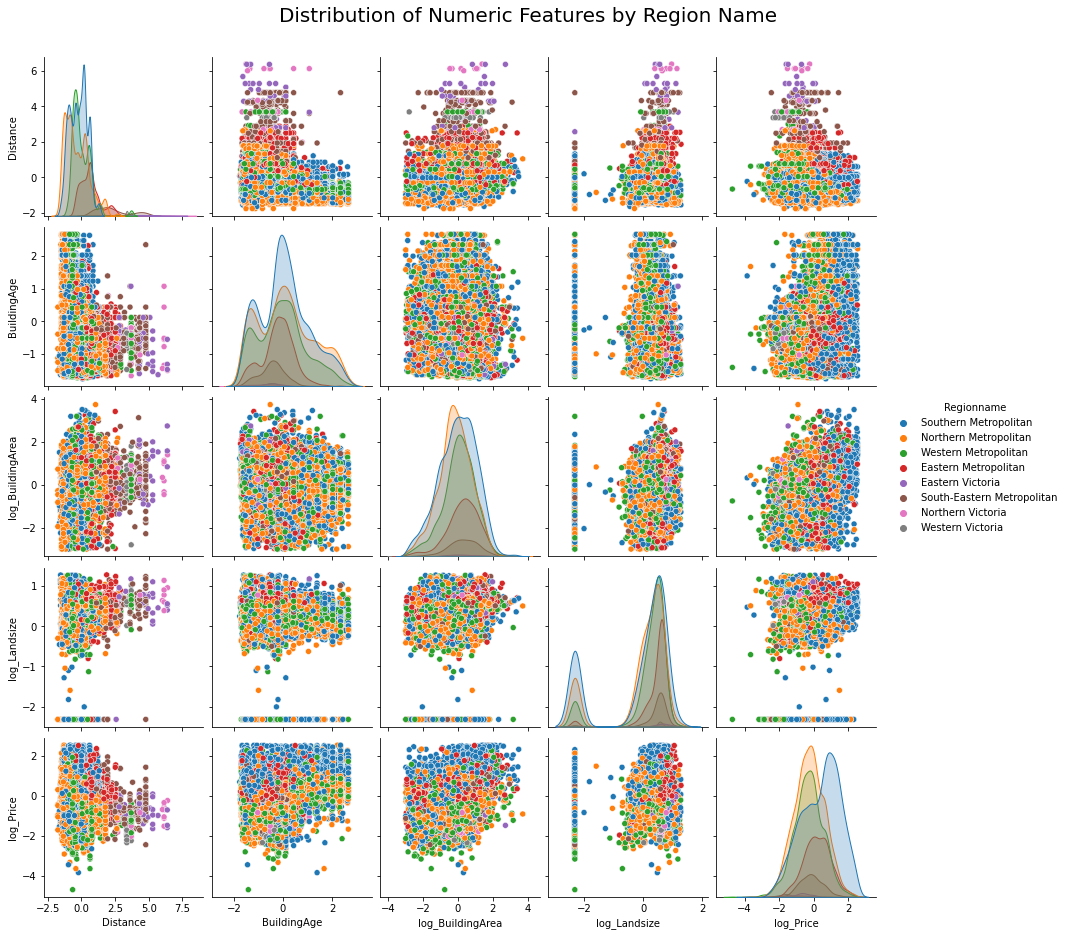

In [14]:
# Show pairplot and distinguish between different property types
b = sns.pairplot(data, hue='Regionname')
b.fig.suptitle('Distribution of Numeric Features by Region Name', y=1.04, fontsize=20);

#### Observation
- We can see clusters begin to appear when we set the hue to 'Type', but settting to 'Regionname' does not produce similar results
- This makes sense as the differences between property types is easier to differentiate from the observations available

<a id="t4.1."></a>
# Property Type Datasets

In [15]:
# Select all numeric features
ni = df_org[['Price','log_Price','Type','Regionname','Distance',
             'log_BuildingArea','log_Landsize','YearSold','YearBuilt',]]

In [16]:
# Create feature inidicating the age of the building
ni['BuildingAge'] = ni['YearSold']-ni['YearBuilt']

In [17]:
# Remove columns used to create the feature above
ni.drop(labels=['YearSold','YearBuilt'],axis=1,inplace=True)

## Standard Scaler
- A note here about standard scaler application

In [18]:
# Apply standard scaler to the data
ni = StandardScaler().fit_transform(ni[['Distance', 'BuildingAge', 'log_BuildingArea',
       'log_Landsize', 'log_Price']])

In [19]:
# Concat the 'target feature' back into the dataset
# Again this will allows us to score the model and find properties that are over/under valued 
ni = pd.DataFrame(data)
ni = pd.concat([ni,df_org['Price']],axis=1)
ni.head()

,Distance,BuildingAge,log_BuildingArea,log_Landsize,log_Price,Type,Regionname,Price
0,0.086270,-0.041036,1.690504,0.642503,0.638382,h,Southern Metropolitan,1270000.0
1,0.309662,-0.295780,-0.835839,0.257971,-1.101741,h,Northern Metropolitan,526250.0
2,-0.463618,1.328213,0.679931,0.485746,0.881022,h,Western Metropolitan,1436000.0
3,0.051902,1.232684,0.664588,0.647447,-0.030882,h,Western Metropolitan,905000.0
4,-0.772930,0.213708,0.828982,0.640011,1.190991,h,Northern Metropolitan,1680000.0


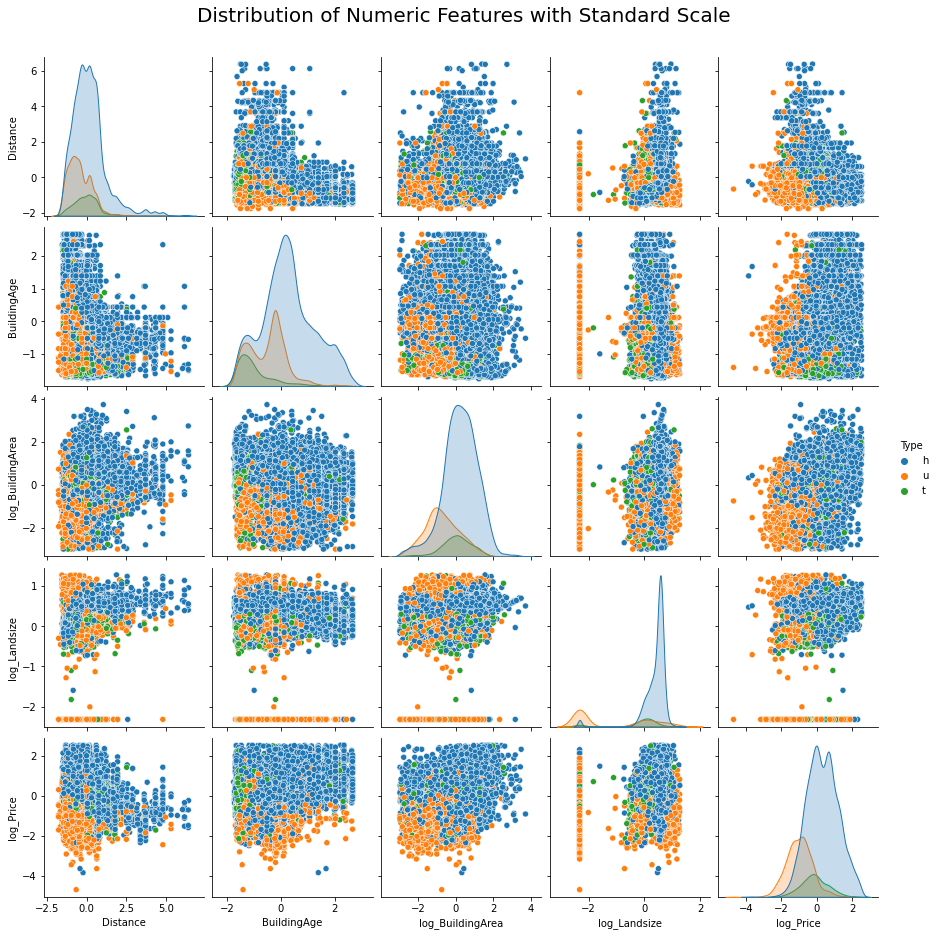

In [20]:
# View pairplot of numeric scaled features
g = sns.pairplot(ni[['Distance','BuildingAge','log_BuildingArea','log_Landsize','log_Price','Type']],hue='Type')
g.fig.suptitle('Distribution of Numeric Features with Standard Scale', y=1.04, fontsize=20);
#plt.savefig('12345678',dpi=300)

In [21]:
# Create subsets for each property type
# And view the length of each new dataframe
df_h = ni[ni['Type']=='h']
df_u = ni[ni['Type']=='u']
df_t = ni[ni['Type']=='t']
print('Length of Each Dataset:')
print(f"House: {len(df_h)}")
print(f"Unit/Appt: {len(df_u)}")
print(f"Townhouse: {len(df_t)}")

Length of Each Dataset:
House: 9158
Unit/Appt: 2892
Townhouse: 1067


In [22]:
# Find the mean value for each property type
print(f"Avergae House price is: ${df_h['Price'].mean():.2f}")
print(f"Avergae Unit/Appartment price is: ${df_u['Price'].mean():.2f}")
print(f"Avergae Townhouse price is: ${df_t['Price'].mean():.2f}")

Avergae House price is: $1197611.71
Avergae Unit/Appartment price is: $600446.21
Avergae Townhouse price is: $933462.37


### Observation
- There is a clear distinction in price difference between the different property types
- Through the process of clustering/k-means can we identify if specific groups of houses appear?
- Can we identify which properties will fall above or below the market average?

<a id="t4.2."></a>
## Feature Engineering - Over/Under Indicator

Create a feature for each data set. This new feature will indicate if the property falls above or below the market average for that property type. For our example the following will be true:
- 1 - Above market value
- 0 - Under Market value

In [23]:
# Add feature to each dataset indicating if the property is above or below the market average
df_h['Avg'] = np.where(df_h['Price']>(df_h['Price'].mean()),1,0)
df_u['Avg'] = np.where(df_u['Price']>(df_u['Price'].mean()),1,0)
df_t['Avg'] = np.where(df_t['Price']>(df_t['Price'].mean()),1,0)

In [24]:
# Inspect results/view new feature
df_h.head()

,Distance,BuildingAge,log_BuildingArea,log_Landsize,log_Price,Type,Regionname,Price,Avg
0,0.086270,-0.041036,1.690504,0.642503,0.638382,h,Southern Metropolitan,1270000.0,1
1,0.309662,-0.295780,-0.835839,0.257971,-1.101741,h,Northern Metropolitan,526250.0,0
2,-0.463618,1.328213,0.679931,0.485746,0.881022,h,Western Metropolitan,1436000.0,1
3,0.051902,1.232684,0.664588,0.647447,-0.030882,h,Western Metropolitan,905000.0,0
4,-0.772930,0.213708,0.828982,0.640011,1.190991,h,Northern Metropolitan,1680000.0,1


<a id="t5."></a>
# Principal Component Analysis

In [25]:
# Creating new dataframes here as we might want to use the regionname data later
# Also not resetting the index this time, can allow for easier merging of this data later
df_house = df_h[['log_BuildingArea','log_Landsize','BuildingAge','Distance']]
df_unit = df_u[['log_BuildingArea','log_Landsize','BuildingAge','Distance']]
df_town = df_t[['log_BuildingArea','log_Landsize','BuildingAge','Distance']]

In [26]:
# Apply PCA 
from sklearn.decomposition import PCA
pca_h = PCA(n_components=2)
pca_u = PCA(n_components=2)
pca_t = PCA(n_components=2)

In [27]:
# Fit the data from the PCA
pca_h.fit(df_house)
pca_u.fit(df_unit)
pca_t.fit(df_town)

PCA(n_components=2)

In [28]:
# Transform the data from the PCA
h_pca = pca_h.transform(df_house)
u_pca = pca_u.transform(df_unit)
t_pca = pca_t.transform(df_town)

In [29]:
# Check shape
h_pca.shape

(9158, 2)

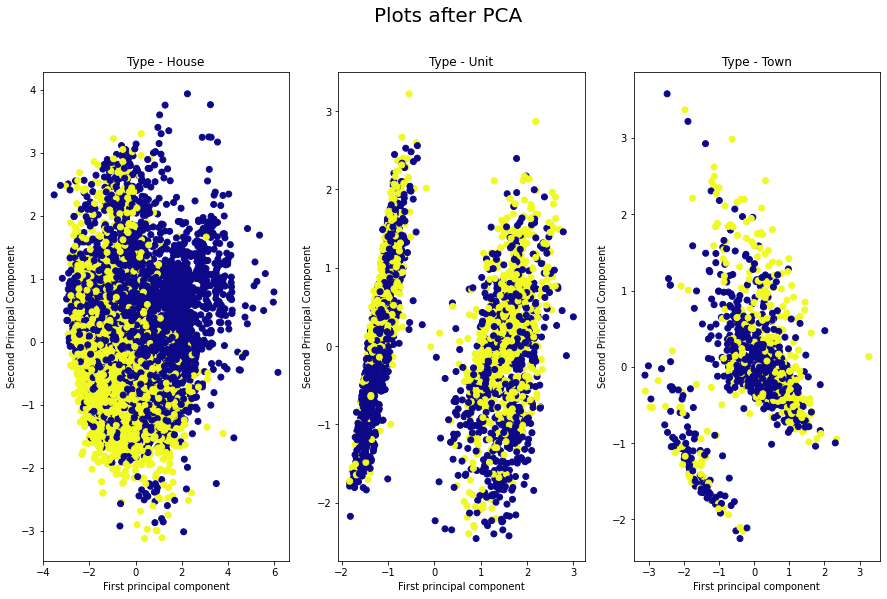

In [30]:
plt.figure(figsize=(15,9))
plt.suptitle('Plots after PCA',fontsize=20)

# House
plt.subplot(1,3,1)
plt.scatter(h_pca[:,0],h_pca[:,1],c=df_h['Avg'],cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.title('Type - House')

# Unit
plt.subplot(1,3,2)
plt.scatter(u_pca[:,0],u_pca[:,1],c=df_u['Avg'],cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.title('Type - Unit')

# Townhouse
plt.subplot(1,3,3)
plt.scatter(t_pca[:,0],t_pca[:,1],c=df_t['Avg'],cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.title('Type - Town')

plt.savefig('4567',dpi=300)

<a id="t5.1."></a>
## Understanding the PCA
To better understand how the principal component analysis transformed the data into the two features required we can create heatmaps. A PCA was done for each seperate dataset as we hypothesised that different property types have different relationships to the features. The following section looks to explore these relationships in more detail through heatmaps. A detailed description of these heatmaps can be found in the accompanying report.

In [31]:
# Print out component correlation
print('Dataset Feature Correlations:')
print('House type componemt correlation')
print(pca_h.components_)
print('-'*52)
print('Appartment/Unit type componemt correlation')
print(pca_u.components_)
print('-'*52)
print('Townhouse type componemt correlation')
print(pca_t.components_)


Dataset Feature Correlations:
House type componemt correlation
[[ 0.26360129  0.10721557 -0.63160124  0.72117894]
 [-0.95368624 -0.05047447 -0.08081408  0.2853138 ]]
----------------------------------------------------
Appartment/Unit type componemt correlation
[[ 0.23021334  0.93831783 -0.02497994  0.25678294]
 [ 0.95623852 -0.25935515 -0.1094479   0.07977434]]
----------------------------------------------------
Townhouse type componemt correlation
[[ 0.53323539  0.68165494 -0.13583894  0.48223889]
 [-0.37224718  0.58571585  0.68440168 -0.22352476]]


In [32]:
# Create datasets to fold the correlation of components
df_comp_h = pd.DataFrame(pca_h.components_,columns=df_house.columns)
df_comp_u = pd.DataFrame(pca_u.components_,columns=df_unit.columns)
df_comp_t = pd.DataFrame(pca_t.components_,columns=df_town.columns)

Text(0.5, 1.0, 'House Type Component Correlation')

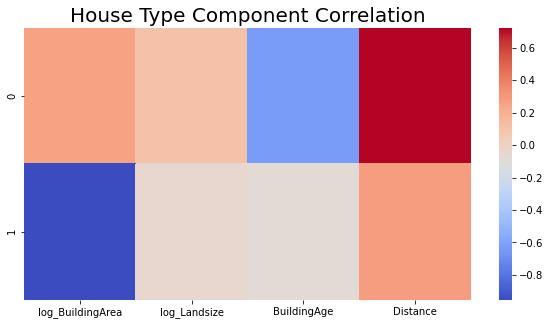

In [33]:
# House
plt.figure(figsize=(10,5))
sns.heatmap(df_comp_h,cmap='coolwarm',)
plt.title('House Type Component Correlation',fontsize=20)

Text(0.5, 1.0, 'Appt/Unit Type Component Correlation')

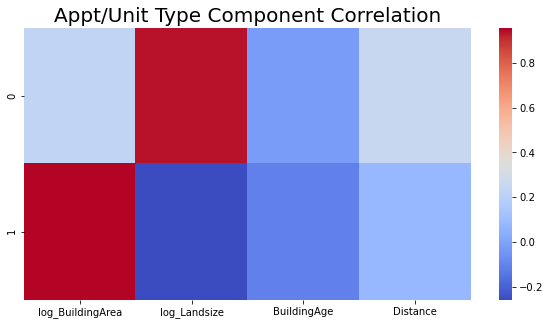

In [34]:
# Appartment/Unit
plt.figure(figsize=(10,5))
sns.heatmap(df_comp_u,cmap='coolwarm',)
plt.title('Appt/Unit Type Component Correlation',fontsize=20)

Text(0.5, 1.0, 'Townhouse Type Component Correlation')

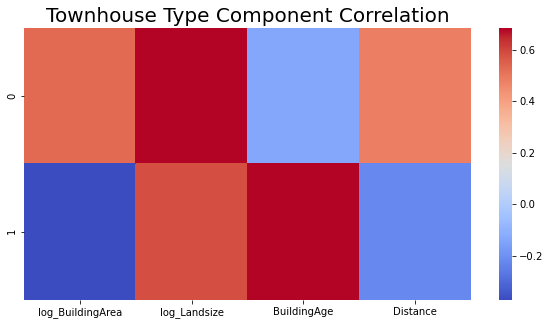

In [35]:
# Townhouse
plt.figure(figsize=(10,5))
sns.heatmap(df_comp_t,cmap='coolwarm',)
plt.title('Townhouse Type Component Correlation',fontsize=20)

<a id="t6."></a>
# Clustering With K-Means

In [36]:
# Create clustering using k-Means
kmeans_h = KMeans(n_clusters=2)
kmeans_u = KMeans(n_clusters=2)
kmeans_t = KMeans(n_clusters=2)

In [37]:
# Fit the data to our models
kmeans_h.fit(h_pca)
kmeans_u.fit(u_pca)
kmeans_t.fit(t_pca)

KMeans(n_clusters=2)

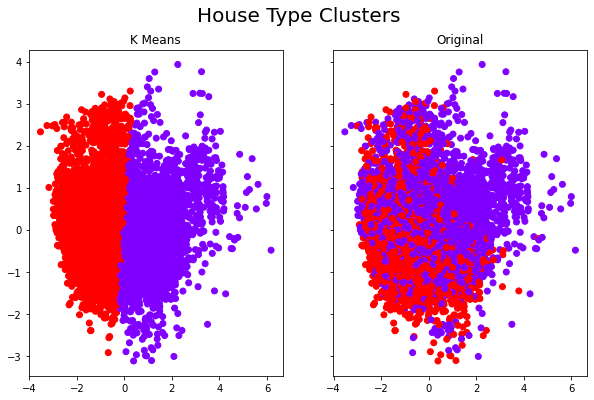

In [38]:
# Houses
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,6))
plt.suptitle('House Type Clusters',fontsize=20)
ax1.set_title('K Means')
ax1.scatter(h_pca[:,0],h_pca[:,1],c=kmeans_h.labels_,cmap='rainbow')
ax2.set_title("Original")
ax2.scatter(h_pca[:,0],h_pca[:,1],c=df_h['Avg'],cmap='rainbow')

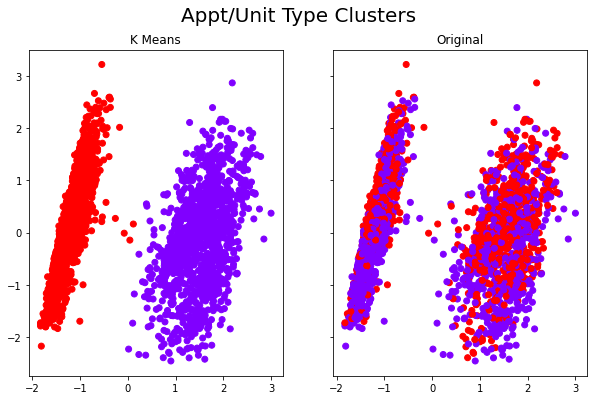

In [39]:
# Unit
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,6))
plt.suptitle('Appt/Unit Type Clusters',fontsize=20)
ax1.set_title('K Means')
ax1.scatter(u_pca[:,0],u_pca[:,1],c=kmeans_u.labels_,cmap='rainbow')
ax2.set_title("Original")
ax2.scatter(u_pca[:,0],u_pca[:,1],c=df_u['Avg'],cmap='rainbow')

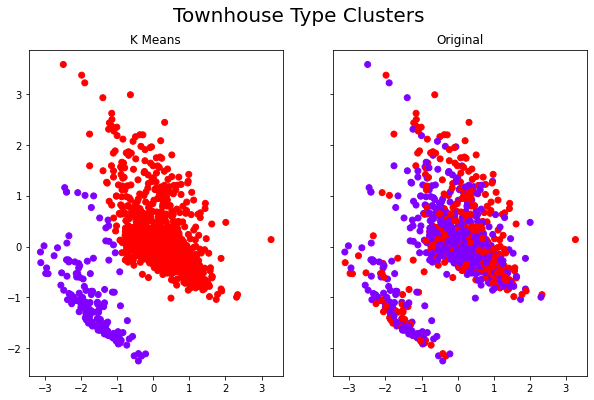

In [40]:
# Townhouse
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,6))
plt.suptitle('Townhouse Type Clusters',fontsize=20)
ax1.set_title('K Means')
ax1.scatter(t_pca[:,0],t_pca[:,1],c=kmeans_t.labels_,cmap='rainbow')
ax2.set_title("Original")
ax2.scatter(t_pca[:,0],t_pca[:,1],c=df_t['Avg'],cmap='rainbow')

<a id="t6.1."></a>
## Model Scoring
Since we have access to the data labels, which is not always the case in unsupervised learning, we can score the models. We will compare the actual designations of over/under valuation to what the model predicted.

In [41]:
# House
print('House Type Scores:')
print(confusion_matrix(df_h['Avg'],kmeans_h.labels_))
print(classification_report(df_h['Avg'],kmeans_h.labels_))

House Type Scores:
[[3159 2120]
 [1624 2255]]
              precision    recall  f1-score   support

           0       0.66      0.60      0.63      5279
           1       0.52      0.58      0.55      3879

    accuracy                           0.59      9158
   macro avg       0.59      0.59      0.59      9158
weighted avg       0.60      0.59      0.59      9158



In [42]:
# Appartment
print('Unit Type Scores:')
print(confusion_matrix(df_u['Avg'],kmeans_u.labels_))
print(classification_report(df_u['Avg'],kmeans_u.labels_))

Unit Type Scores:
[[ 620 1067]
 [ 653  552]]
              precision    recall  f1-score   support

           0       0.49      0.37      0.42      1687
           1       0.34      0.46      0.39      1205

    accuracy                           0.41      2892
   macro avg       0.41      0.41      0.40      2892
weighted avg       0.43      0.41      0.41      2892



In [43]:
# Townhouse
print('Townhouse Type Scores:')
print(confusion_matrix(df_t['Avg'],kmeans_t.labels_))
print(classification_report(df_t['Avg'],kmeans_t.labels_))

Townhouse Type Scores:
[[ 98 541]
 [ 49 379]]
              precision    recall  f1-score   support

           0       0.67      0.15      0.25       639
           1       0.41      0.89      0.56       428

    accuracy                           0.45      1067
   macro avg       0.54      0.52      0.41      1067
weighted avg       0.56      0.45      0.37      1067



#### Observation
- When creating 2 clusters through the k-means model we achieve the following scores:
    - House: 59%
    - Unit: 41%
    - Townhouse: 45%
- What these scores tell us, is that with the features available to us we have identified some over/under valued properties
- From these scores we can say that the inverse of the accuracy represent the percentage of porperties that are incorrectly priced

<a id="t7."></a>
# Model Improvment
By utilizing the Elbow plot technique, we will look to change the number of clusters in our data set. In doing so we hope to change from a simple over/undervalued approach to identifying price brackets 

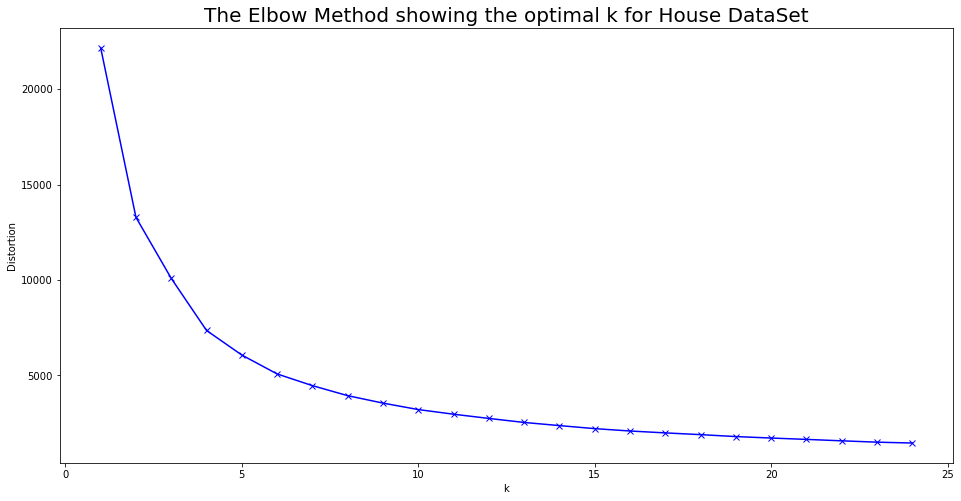

In [44]:
# Elbow plot for House Type      
distortions = []
K = range(1,25)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(h_pca)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k for House DataSet',fontsize=20)
plt.show()

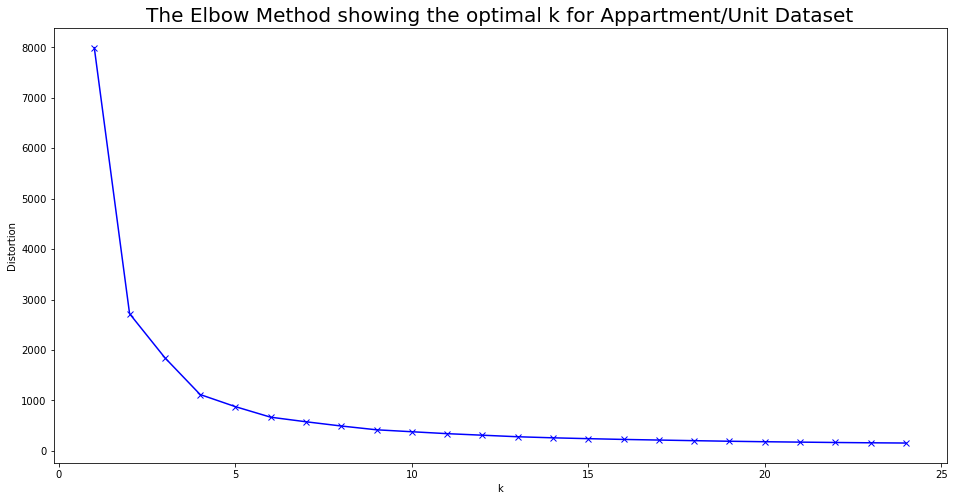

In [45]:
# Elbow plot for Unit/Apt Type
distortions = []
K = range(1,25)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(u_pca)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k for Appartment/Unit Dataset',fontsize=20)
plt.show()

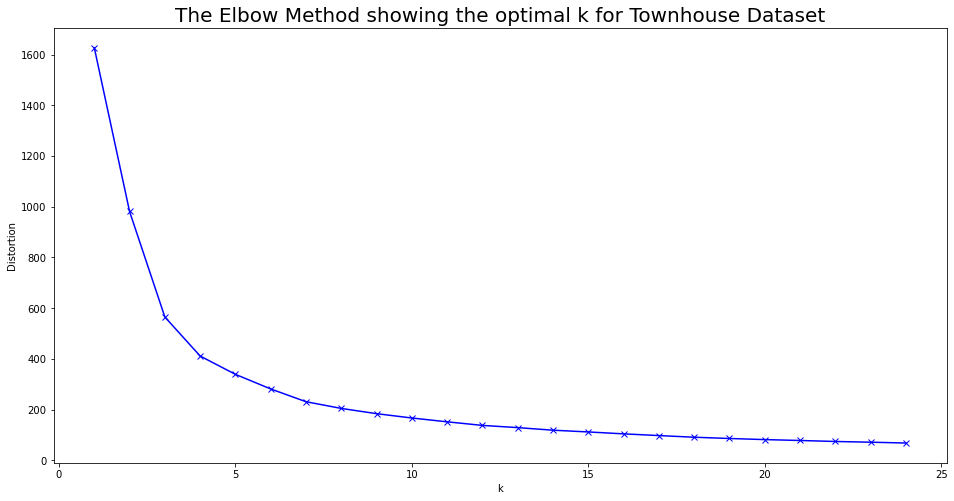

In [46]:
# Elbow plot for Townhouse Type
distortions = []
K = range(1,25)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(t_pca)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k for Townhouse Dataset',fontsize=20)
plt.show()

<a id="t8."></a>
# Second Iteration of Clustering
Now that we have identified the correct number of clusters by utilizing the Elbow plot method we can look to imporve our models

In [47]:
# Do clustering again with new cluster numbers
kmeans_h2 = KMeans(n_clusters=6)
kmeans_u2 = KMeans(n_clusters=4)
kmeans_t2 = KMeans(n_clusters=6)

In [48]:
# Fit the data
kmeans_h2.fit(h_pca)
kmeans_u2.fit(u_pca)
kmeans_t2.fit(t_pca)

KMeans(n_clusters=6)

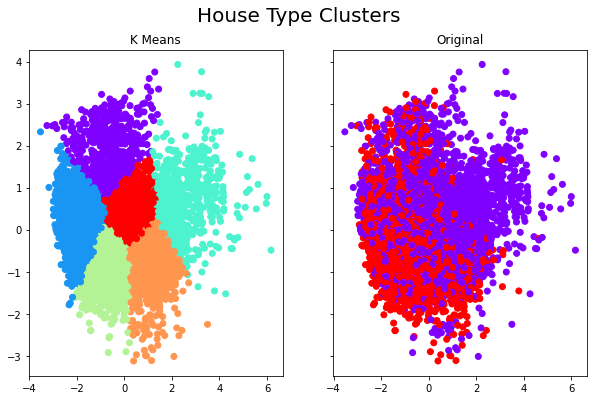

In [49]:
# Houses
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,6))
plt.suptitle('House Type Clusters',fontsize=20)
ax1.set_title('K Means')
ax1.scatter(h_pca[:,0],h_pca[:,1],c=kmeans_h2.labels_,cmap='rainbow')
ax2.set_title("Original")
ax2.scatter(h_pca[:,0],h_pca[:,1],c=df_h['Avg'],cmap='rainbow')

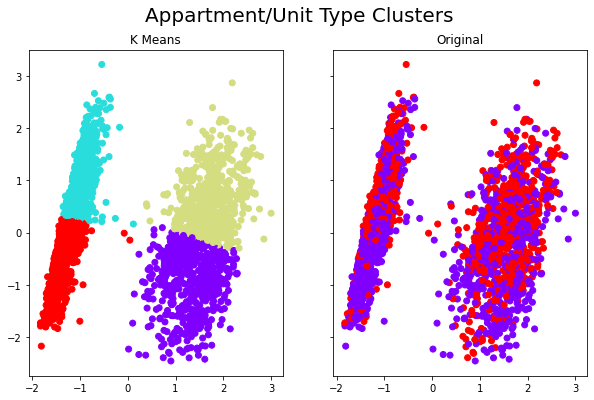

In [50]:
# Unit
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,6))
plt.suptitle('Appartment/Unit Type Clusters',fontsize=20)
ax1.set_title('K Means')
ax1.scatter(u_pca[:,0],u_pca[:,1],c=kmeans_u2.labels_,cmap='rainbow')
ax2.set_title("Original")
ax2.scatter(u_pca[:,0],u_pca[:,1],c=df_u['Avg'],cmap='rainbow')

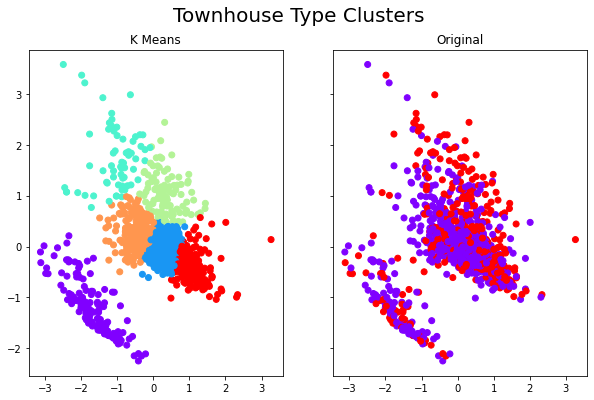

In [51]:
# Townhouse
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,6))
plt.suptitle('Townhouse Type Clusters',fontsize=20)
ax1.set_title('K Means')
ax1.scatter(t_pca[:,0],t_pca[:,1],c=kmeans_t2.labels_,cmap='rainbow')
ax2.set_title("Original")
ax2.scatter(t_pca[:,0],t_pca[:,1],c=df_t['Avg'],cmap='rainbow')

<a id="t8.1."></a>
## Feature Engineering - Price Bins
In order to score our models again we need to create price bins for each data set that reflects the number of clusters identified in the Elbow plot method

In [52]:
# Create bins for Price to reflect the elbow plot suggested number of plots
bin_labels_6 = [1, 2, 3, 4, 5,6]
bin_labels_4 = [1,2,3,4]

# House
df_h['Price_Bin'] = pd.qcut(df_h['Price'],q=6,labels=bin_labels_6)

# Unit
df_u['Price_Bin'] = pd.qcut(df_u['Price'],q=4,labels=bin_labels_4)

# Townhouse
df_t['Price_Bin'] = pd.qcut(df_t['Price'],q=6,labels=bin_labels_6)

<a id="t9."></a>
# Third Iteration of Clustering
Now that we have identified the optimal number of clusters we will re fit our model and score it again.
This time instead of just comparing as above or below, we are looking to see if properties fall into their correct price category.

In [53]:
# Do clustering again with new cluster numbers
kmeans_h3 = KMeans(n_clusters=6)
kmeans_u3 = KMeans(n_clusters=4)
kmeans_t3 = KMeans(n_clusters=6)

In [54]:
# Fit the data
kmeans_h3.fit(h_pca)
kmeans_u3.fit(u_pca)
kmeans_t3.fit(t_pca)

KMeans(n_clusters=6)

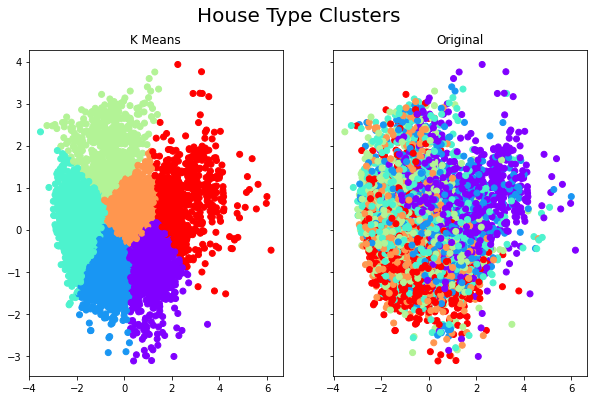

In [55]:
# Houses
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,6))
plt.suptitle('House Type Clusters',fontsize=20)
ax1.set_title('K Means')
ax1.scatter(h_pca[:,0],h_pca[:,1],c=kmeans_h3.labels_,cmap='rainbow')
ax2.set_title("Original")
ax2.scatter(h_pca[:,0],h_pca[:,1],c=df_h['Price_Bin'],cmap='rainbow')

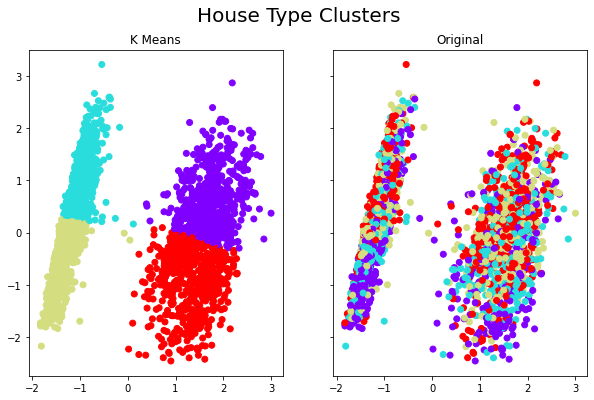

In [56]:
# Houses
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,6))
plt.suptitle('House Type Clusters',fontsize=20)
ax1.set_title('K Means')
ax1.scatter(u_pca[:,0],u_pca[:,1],c=kmeans_u3.labels_,cmap='rainbow')
ax2.set_title("Original")
ax2.scatter(u_pca[:,0],u_pca[:,1],c=df_u['Price_Bin'],cmap='rainbow')

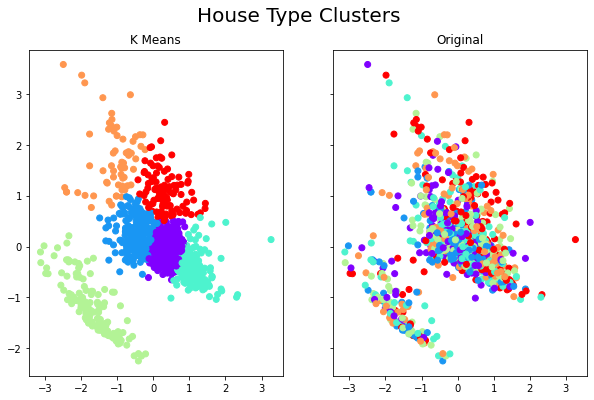

In [57]:
# Houses
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,6))
plt.suptitle('House Type Clusters',fontsize=20)
ax1.set_title('K Means')
ax1.scatter(t_pca[:,0],t_pca[:,1],c=kmeans_t3.labels_,cmap='rainbow')
ax2.set_title("Original")
ax2.scatter(t_pca[:,0],t_pca[:,1],c=df_t['Price_Bin'],cmap='rainbow')

<a id="t9.1."></a>
## Scoring of Third Iteration

In [58]:
# House
print('House Type Scores:')
print(confusion_matrix(df_h['Price_Bin'],kmeans_h3.labels_))
print(classification_report(df_h['Price_Bin'],kmeans_h3.labels_))

House Type Scores:
[[  0   0   0   0   0   0   0]
 [246  51  26 142 668 432   0]
 [279 170 173 118 577 184   0]
 [279 256 325 130 428  95   0]
 [339 285 406 110 375  36   0]
 [312 426 389  88 294  13   0]
 [380 642 272  52 153   7   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.03      0.03      0.03      1565
           2       0.11      0.12      0.11      1501
           3       0.20      0.09      0.12      1513
           4       0.15      0.24      0.19      1551
           5       0.02      0.01      0.01      1522
           6       0.00      0.00      0.00      1506

    accuracy                           0.08      9158
   macro avg       0.07      0.07      0.07      9158
weighted avg       0.08      0.08      0.08      9158



In [59]:
# Unit
print('House Type Scores:')
print(confusion_matrix(df_u['Price_Bin'],kmeans_u3.labels_))
print(classification_report(df_u['Price_Bin'],kmeans_u3.labels_))

House Type Scores:
[[  0   0   0   0   0]
 [ 77 117 365 165   0]
 [127 133 318 162   0]
 [158 161 206 180   0]
 [246 220  99 158   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.19      0.16      0.17       724
           2       0.32      0.43      0.37       740
           3       0.27      0.26      0.26       705
           4       0.00      0.00      0.00       723

    accuracy                           0.21      2892
   macro avg       0.16      0.17      0.16      2892
weighted avg       0.19      0.21      0.20      2892



In [60]:
# Townhouse
print('House Type Scores:')
print(confusion_matrix(df_t['Price_Bin'],kmeans_t3.labels_))
print(classification_report(df_t['Price_Bin'],kmeans_t3.labels_))

House Type Scores:
[[ 0  0  0  0  0  0  0]
 [62 62 21 23 12  6  0]
 [66 51 17 22  7  9  0]
 [65 37 32 24  9 13  0]
 [51 33 41 24  8 17  0]
 [43 28 51 22 14 20  0]
 [46 16 50 15 12 38  0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.27      0.33      0.30       186
           2       0.08      0.10      0.09       172
           3       0.18      0.13      0.15       180
           4       0.13      0.05      0.07       174
           5       0.19      0.11      0.14       178
           6       0.00      0.00      0.00       177

    accuracy                           0.12      1067
   macro avg       0.12      0.10      0.11      1067
weighted avg       0.15      0.12      0.13      1067

